In [1]:
import pandas as pd
import numpy as np
import random

import os
import gzip
import json
import time

np.random.seed(0)

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df_ = {}
    for d in parse(path):
        df_[i] = d
        i += 1
    return pd.DataFrame.from_dict(df_, orient='index')

In [4]:
_f = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
start = time.time()
fd = getDF(_f)
print('Total time taken for loading the dataframe:', time.time() - start)
print(fd.columns)
print(len(fd))
print(fd.head(1))

Total time taken for loading the dataframe: 17.310710668563843
Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
278677
       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   

                         summary  unixReviewTime   reviewTime  
0  Great tutu-  not cheaply made      1297468800  02 12, 2011  


In [5]:
df_fd = fd[['reviewerID', 'asin','overall']]
df_fd['date'] = pd.to_datetime(fd['reviewTime'])
df_fd.sort_values(by = 'date', inplace = True)
df_fd["dayOfweek"] = df_fd.date.dt.weekday_name
df_fd.head(5)

/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

,reviewerID,asin,overall,date,dayOfweek
3434,A1X2LENOF84LCQ,B0000ZEPGA,5.0,2003-03-29,Saturday
145,A1GPGBHBI6T2HJ,B000051SEP,5.0,2003-12-12,Friday
13199,A1Z54EM24Y40LL,B0007YXUS8,5.0,2004-07-17,Saturday
2017,A2K3J2X8KDY47N,B0000B35EL,2.0,2004-09-24,Friday
1963,AB2YZA2HLY75H,B0000B35D9,5.0,2004-09-29,Wednesday


### EDA

In [6]:
df_fd.describe()

,overall
count,278677.000000
mean,4.245133
std,1.103747
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
print("Number of NaN values: \n"+str(df_fd.isnull().sum()))

Number of NaN values: 
reviewerID    0
asin          0
overall       0
date          0
dayOfweek     0
dtype: int64


In [8]:
duplicates = df_fd.duplicated(['reviewerID', 'asin','overall'])
print("Number of duplicate rows: "+str(duplicates.sum()))

Number of duplicate rows: 0


In [9]:
print("Clothing, Shoes & Jewelry review data:")
print("Number of product ratings = "+str(df_fd.shape[0]))
print("Number of unique users = "+str(len(np.unique(df_fd['reviewerID']))))
print("Number of unique products = "+str(len(np.unique(df_fd['asin']))))

Clothing, Shoes & Jewelry review data:
Number of product ratings = 278677
Number of unique users = 39387
Number of unique products = 23033


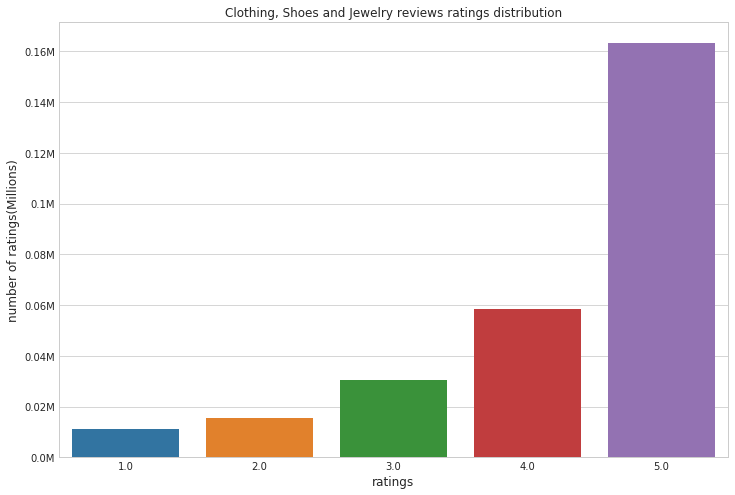

In [10]:
no_of_reviews_per_product = df_fd.groupby(by = 'asin')['overall'].count().sort_values(ascending = False)

no_of_reviews_per_user = df_fd.groupby(by = 'reviewerID')['overall'].count().sort_values(ascending = False)

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="overall", data=df_fd)

ax.set_yticklabels([str(num/10**6) + "M" for num in ax.get_yticks()])

plt.tick_params(labelsize = 10)
plt.title("Clothing, Shoes and Jewelry reviews ratings distribution", fontsize = 12)
plt.xlabel("ratings", fontsize = 12)
plt.ylabel("number of ratings(Millions)", fontsize = 12)
plt.show()

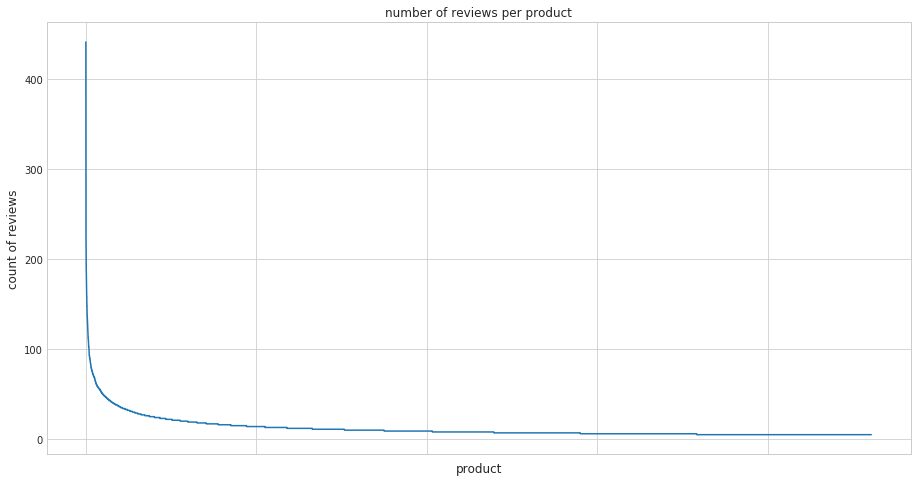

In [11]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("number of reviews per product", fontsize = 12)
plt.xlabel("product", fontsize = 12)
plt.ylabel("count of reviews", fontsize = 12)
plt.plot(no_of_reviews_per_product.values)
plt.tick_params(labelsize = 10)
axes.set_xticklabels([])
plt.show()

It is very skewed

It clearly shows that there are some products that are very popular and were rated by many users as comapared to others.

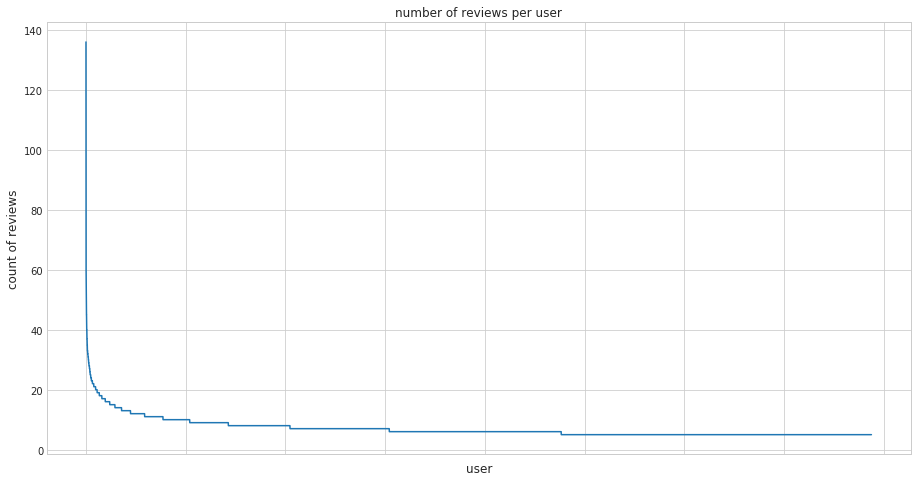

In [12]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("number of reviews per user", fontsize = 12)
plt.xlabel("user", fontsize = 12)
plt.ylabel("count of reviews", fontsize = 12)
plt.plot(no_of_reviews_per_user.values)
plt.tick_params(labelsize = 10)
axes.set_xticklabels([])
plt.show()

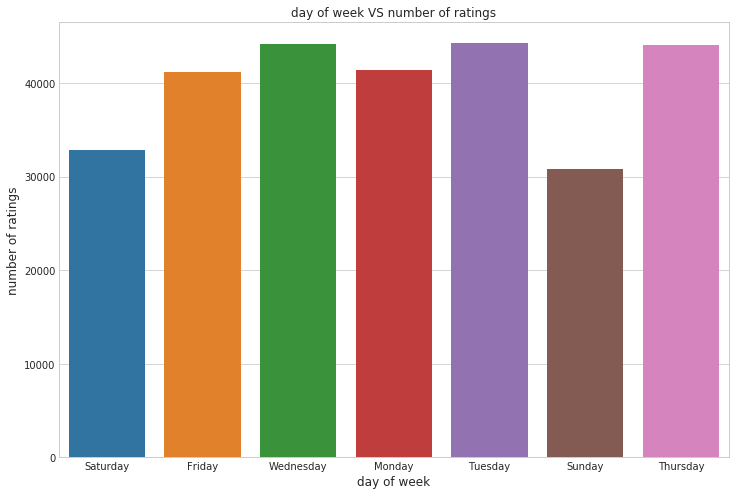

In [13]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "dayOfweek", data = df_fd)
axes.set_title("day of week VS number of ratings", fontsize = 12)
axes.set_xlabel("day of week", fontsize = 12)
axes.set_ylabel("number of ratings", fontsize = 12)
ax.set_yticklabels([str(num/10**6) + "M" for num in ax.get_yticks()])
axes.tick_params(labelsize = 10)

plt.show()

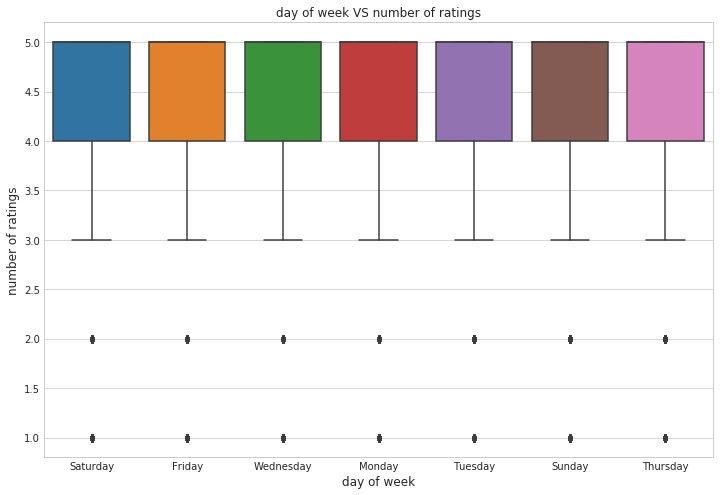

In [14]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "dayOfweek", y = "overall", data = df_fd)
axes.set_title("day of week VS number of ratings", fontsize = 12)
axes.set_xlabel("day of week", fontsize = 12)
axes.set_ylabel("number of ratings", fontsize = 12)
axes.tick_params(labelsize = 10)

plt.show()

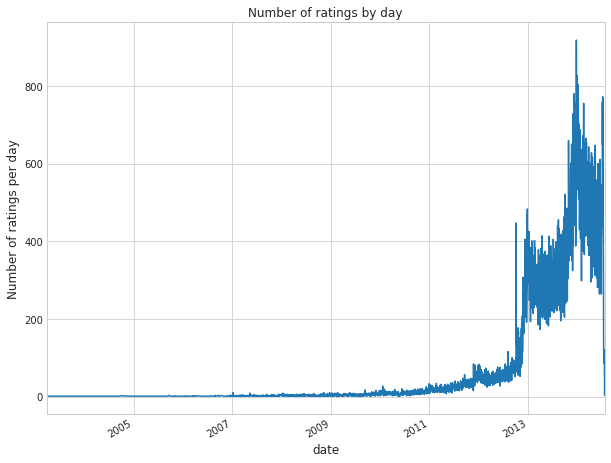

In [15]:
plt.figure(figsize = (10,8))

ax = df_fd.groupby(by = 'date')['overall'].count().plot()
ax.set_title("Number of ratings by day", fontsize = 12)
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Number of ratings per day", fontsize = 12)
plt.tick_params(labelsize = 10)
plt.show()

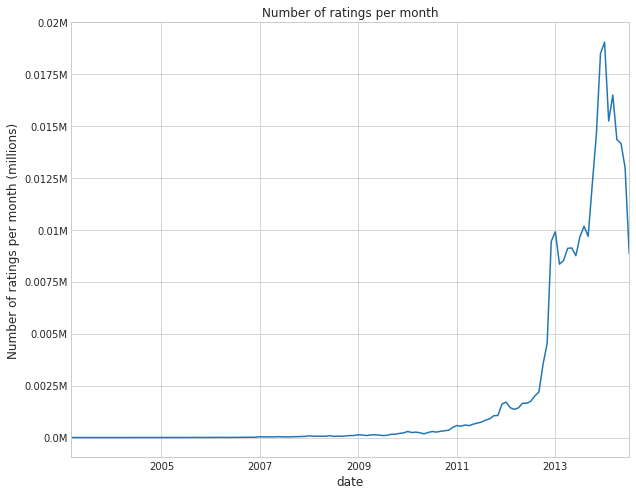

In [16]:
plt.figure(figsize = (10,8))
ax = df_fd.resample("M", on = "date")["overall"].count().plot()
ax.set_yticklabels([str(num/10**6) + "M" for num in ax.get_yticks()])
ax.set_title("Number of ratings per month", fontsize = 12)
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Number of ratings per month (millions)", fontsize = 12)
plt.tick_params(labelsize = 10)
plt.show()

In [17]:
# no_of_reviews_per_product = df_fd.groupby(by = 'asin')['overall'].count().sort_values(ascending = False)

# no_of_reviews_per_user = df_fd.groupby(by = 'reviewerID')['overall'].count().sort_values(ascending = False)

# no_of_rated_products_per_user = df_fd.groupby(by = "reviewerID")["overall"].count().sort_values(ascending = False)
# no_of_rated_products_per_user.head()

/home/elkayvee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


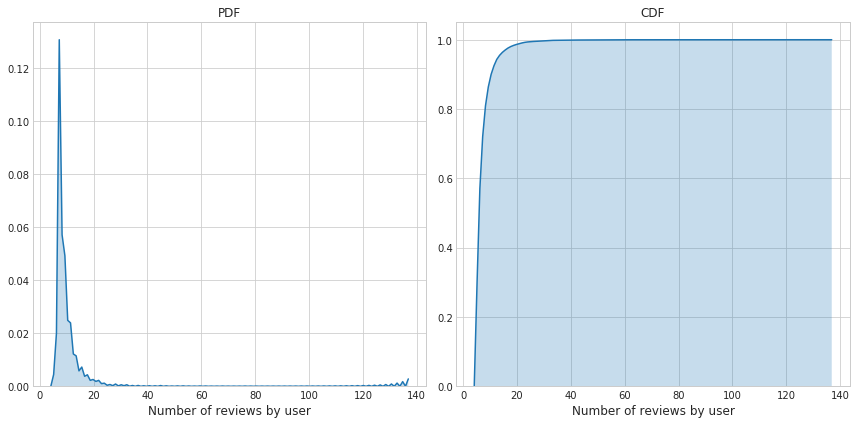

In [18]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))

sns.kdeplot(no_of_reviews_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 12)
axes[0].set_xlabel("Number of reviews by user", fontsize = 12)
axes[0].tick_params(labelsize = 10)

sns.kdeplot(no_of_reviews_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 12)
axes[1].set_xlabel("Number of reviews by user", fontsize = 12)
axes[1].tick_params(labelsize = 10)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()


As expected, above PDF graph shows that almost all of the users give very few ratings. 
There are very few users who's ratings count is high.

Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [19]:
quantiles = no_of_reviews_per_user.quantile(np.arange(0,1.01,0.01))

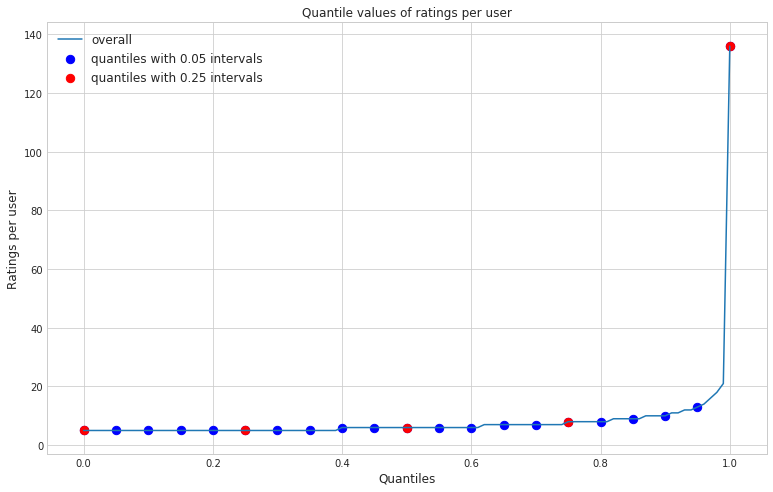

In [20]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of ratings per user", fontsize = 12)
axes.set_xlabel("Quantiles", fontsize = 12)
axes.set_ylabel("Ratings per user", fontsize = 12)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5],  y = quantiles.values[::5],  c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red",  s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 12)
    
axes.tick_params(labelsize = 10)

In [21]:
start = time.time()
rp = df_fd.pivot_table(columns=['asin'],index=['reviewerID'],values='overall')
rp = rp.fillna(0)
print("time taken to create ratings matrix =", np.round((time.time() - start),2))

time taken to create ratings matrix = 100.82784461975098


### Calculation of **Sparsity**

In [22]:
matrix_size = rp.shape[0]*rp.shape[1] # Number of possible interactions in the matrix
num_ratings = len(np.nonzero(rp.as_matrix())[0]) # Number of items interacted with
sparsity = 100*(1 - (num_ratings/matrix_size))
print("sparsity of ratings matrix for users/items:")
np.round(sparsity,3)

sparsity of ratings matrix for users/items:


99.969

In [23]:
rp_ = rp.as_matrix()

In [24]:
# Only get users/items where ratings totals were positive
users = list(np.sort(df_fd.reviewerID.unique())) # Get our unique reviewers
items = list(np.sort(df_fd.asin.unique()))# Get our unique items that were purchased
ratings = list(df_fd.overall) # All of our ratings

# Get the associated row indices
rows = df_fd.reviewerID.astype('category', categories = users).cat.codes 

# Get the associated column indices
cols = df_fd.asin.astype('category', categories = items).cat.codes 

startTime = time.time()
print("Creating USER_ITEM sparse matrix for review data")
if os.path.isfile("rp_.npz"):
    print("Sparse data is already present in your disk, no need to create further. Loading Sparse Matrix")
    rp_ = sparse.load_npz("rp_.npz")
    print("Shape of review ratings Sparse matrix = "+str(rp_.shape))
    
else:
    print("We are creating sparse data")
    rp_ = sparse.csr_matrix((ratings, (rows, cols)), shape=(len(users), len(items)))
    print("Creation done. Shape of sparse matrix = "+str(rp_.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("rp_.npz", rp_)
    print("Done\n")

print(np.round((time.time() - startTime),2))

Creating USER_ITEM sparse matrix for review data
We are creating sparse data
Creation done. Shape of sparse matrix = (39387, 23033)
Saving it into disk for furthur usage.
Done

0.3930947780609131


#### Computing Similarity Matrices
**_User-User_** similarity matrix for **_all_** users

In [25]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def User_UserSimilarity(sparseMatrix, top = 100):
    starttime = time.time()  
    
    row_index, col_index = sparseMatrix.nonzero()  #indices of rows in "row_index" and 
                                                   #indices of columns in "col_index" where a non-zero value exists
    rows = np.unique(row_index)

    similarMatrix = np.zeros((row_index[-1] + 1)*top).reshape((row_index[-1] + 1),top) # row_index*top. As we are building 
                                                                                       # similarity matrix only for top most
                                                                                       # similar users.
    timeTaken = []
    users = 0
    
    for row in rows[:top]:
        users += 1
        startTime = time.time()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top_similar_indices = sim.argsort()[-top:]
        top_similar = sim[top_similar_indices]
        similarMatrix[row] = top_similar
        timeTaken.append(time.time() - startTime)
        
    print("average time taken to compute similarity matrix for 1 user = "+
          str(np.round(sum(timeTaken)/len(timeTaken)),2)+" seconds")
    
    avgTimeTaken = sum(timeTaken)/len(timeTaken)
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time taken per user')
    plt.plot(np.cumsum(timeTaken), label='Time taken - all users')
    plt.legend(loc='upper left', fontsize = 12)
    plt.xlabel('Users', fontsize = 12)
    plt.ylabel('time(seconds)', fontsize = 12)
    plt.tick_params(labelsize = 10)
    plt.show()
    
    return similarMatrix, avgTimeTaken

average time taken to compute similarity matrix for 1 user = 0.006926521953614047 seconds


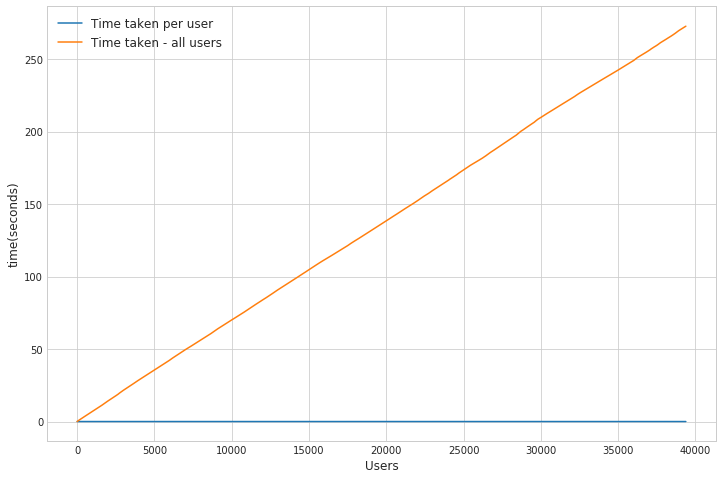

time taken for calculating the similarity matrix for all the users: 273.1226463317871


In [26]:
start_time = time.time()
simMatrix, avgTimeTaken = User_UserSimilarity(rp_, rp_.shape[0])
print("time taken for calculating the similarity matrix for all the users:", np.round((time.time() - start_time),2))

In [27]:
print("total time it would take for similiarity matrix calculation for {} users in the data, would be {} days.".format(rp_.shape[0],np.round((rp_.shape[0]*avgTimeTaken)/(24*60), 2)))

total time it would take for similiarity matrix calculation for 39387 users in the data, would be 0.19 days.


#### Computing Similarity Matrices
**_Item-Item_** similarity matrix for **_all_** items

In [28]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def Item_ItemSimilarity(sparseMatrix, top = 100):
    starttime = time.time()  
    
    row_index, col_index = sparseMatrix.nonzero()  #indices of rows in "row_index" and 
                                                   #indices of columns in "col_index" where a non-zero value exists
    rows = np.unique(row_index)

    similarItemsMatrix = np.zeros((row_index[-1] + 1)*top).reshape((row_index[-1] + 1),top) # row_index*top. As we are building 
                                                                                       # similarity matrix only for top most
                                                                                       # similar users.
    ItemtimeTaken = []
    items = 0
    
    for row in rows[:top]:
        items += 1
        startItemTime = time.time()  #it will give seconds elapsed
        sim_items = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top_similar_item_indices = sim_items.argsort()[-top:]
        top_similar_items = sim_items[top_similar_item_indices]
        similarItemsMatrix[row] = top_similar_items
        ItemtimeTaken.append(time.time() - startItemTime)
        
    print("average time taken to compute similarity matrix for 1 item = "+
          str(np.round(sum(ItemtimeTaken)/len(ItemtimeTaken)),2)+" seconds")
    
    avgItemTimeTaken = sum(ItemtimeTaken)/len(ItemtimeTaken)
    fig = plt.figure(figsize = (12,8))
    plt.plot(ItemtimeTaken, label = 'Time taken per item')
    plt.plot(np.cumsum(ItemtimeTaken), label='Time taken - all items')
    plt.legend(loc='upper left', fontsize = 12)
    plt.xlabel('Items', fontsize = 12)
    plt.ylabel('time(seconds)', fontsize = 12)
    plt.tick_params(labelsize = 10)
    plt.show()
    
    return similarItemsMatrix, avgItemTimeTaken

average time taken to compute similarity matrix for 1 item = 0.013383837377223356 seconds


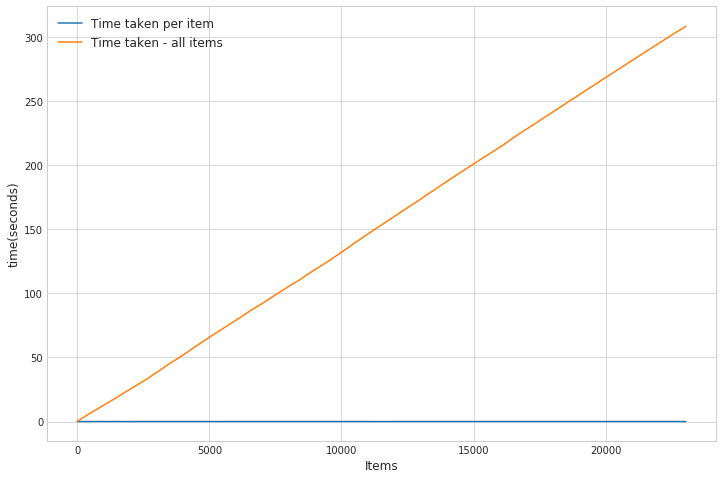

time taken for calculating the similarity matrix for all the items: 308.555881023407


In [29]:
start_time = time.time()
simItemsMatrix, avgItemTimeTaken = Item_ItemSimilarity(rp_.T, rp_.shape[1])
print("time taken for calculating the similarity matrix for all the items:", np.round((time.time() - start),2))

In [30]:
print("total time it would take for similiarity matrix calculation for {} users in the data, would be {} days.".format(rp_.shape[1],np.round((rp_.shape[1]*avgItemTimeTaken)/(24*60), 2)))

total time it would take for similiarity matrix calculation for 23033 users in the data, would be 0.21 days.


In [36]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

In [37]:
product_train, product_test, product_users_altered = make_train(rp_, pct_test = 0.2)

In [38]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
    Implicit weighted ALS taken from Hu, Koren, and Volinsky 2008. Designed for alternating least squares and implicit
    feedback based collaborative filtering. 
    
    parameters:
    
    training_set - Our matrix of ratings with shape m x n, where m is the number of users and n is the number of items.
    Should be a sparse csr matrix to save space. 
    
    lambda_val - Used for regularization during alternating least squares. Increasing this value may increase bias
    but decrease variance. Default is 0.1. 
    
    alpha - The parameter associated with the confidence matrix discussed in the paper, where Cui = 1 + alpha*Rui. 
    The paper found a default of 40 most effective. Decreasing this will decrease the variability in confidence between
    various ratings.
    
    iterations - The number of times to alternate between both user feature vector and item feature vector in
    alternating least squares. More iterations will allow better convergence at the cost of increased computation. 
    The authors found 10 iterations was sufficient, but more may be required to converge. 
    
    rank_size - The number of latent features in the user/item feature vectors. The paper recommends varying this 
    between 20-200. Increasing the number of features may overfit but could reduce bias. 
    
    seed - Set the seed for reproducible results
    
    returns:
    
    The feature vectors for users and items. The dot product of these feature vectors should give you the expected 
    "rating" at each point in your original matrix. 
    '''
    
    # first set up our confidence matrix
    
    conf = (alpha*training_set) # To allow the matrix to stay sparse, I will add one later when each row is taken 
                                # and converted to dense. 
    num_user = conf.shape[0]
    num_item = conf.shape[1] # Get the size of our original ratings matrix, m x n
    
    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)
    
    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x n but we can 
                                                                 # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I. 
    
    # We can compute this before iteration starts. 
    
    # Begin iterations
    print("Begin iteration")
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        print("Begin iteration =", iter_step)
        print("Begin user")
        
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Create binarized preference vector 
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, don't need to subtract 1 since we never added it 
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term 
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu)
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper  
        # Begin iteration to solve for Y based on fixed X 
        
        print("Begin item")
        
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, don't need to subtract 1 since we never added it
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning. 
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons. 

In [ ]:
start = time.time()
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 10,
                                            rank_size = 20)
print("total time taken to run the MF", np.round((time.time() - start),2))

In [48]:
user_vecs[0,:].dot(item_vecs).toarray()[0,:5]

array([ 0.00117737,  0.00461647, -0.01130906,  0.03990974,  0.01435244])

In [49]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   


In [50]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix masked. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark


In [51]:
print(user_vecs.shape, item_vecs.shape)
print(sparse.csr_matrix(user_vecs).shape, sparse.csr_matrix(item_vecs).shape )
print(product_train.shape)
print(product_test.shape)
print(len(product_users_altered))

(39387, 20) (20, 23033)
(39387, 20) (20, 23033)
(39387, 23033)
(39387, 23033)
29909


In [52]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs)], product_test)
# AUC for our recommender system

(0.698, 0.704)

In [53]:
start = time.time()
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 10,
                                            rank_size = 40)
print("total time taken to run the MF", np.round((time.time() - start),2))

Begin iteration
Begin iteration = 0
Begin user
Begin item
Begin iteration = 1
Begin user
Begin item
Begin iteration = 2
Begin user
Begin item
Begin iteration = 3
Begin user
Begin item
Begin iteration = 4
Begin user
Begin item
Begin iteration = 5
Begin user
Begin item
Begin iteration = 6
Begin user
Begin item
Begin iteration = 7
Begin user
Begin item
Begin iteration = 8
Begin user
Begin item
Begin iteration = 9
Begin user
Begin item
total time taken to run the MF 13495.49


In [54]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs)], product_test)

(0.683, 0.704)

In [55]:
start = time.time()
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 40, iterations = 10,
                                            rank_size = 40)
print("total time taken to run the MF", np.round((time.time() - start),2))

Begin iteration
Begin iteration = 0
Begin user
Begin item
Begin iteration = 1
Begin user
Begin item
Begin iteration = 2
Begin user
Begin item
Begin iteration = 3
Begin user
Begin item
Begin iteration = 4
Begin user
Begin item
Begin iteration = 5
Begin user
Begin item
Begin iteration = 6
Begin user
Begin item
Begin iteration = 7
Begin user
Begin item
Begin iteration = 8
Begin user
Begin item
Begin iteration = 9
Begin user
Begin item
total time taken to run the MF 13640.05


In [56]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs)], product_test)

(0.68, 0.704)

In [58]:
import implicit

In [64]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=10, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

100%|██████████| 50.0/50 [00:01<00:00, 37.96it/s]


In [65]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.745, 0.704)

In [69]:
user_vecs.shape

(39387, 10)

In [70]:
rec_vector = user_vecs.dot(item_vecs.T)

In [71]:
users = list(np.sort(df_fd.reviewerID.unique()))
rec_vector.shape

(39387, 23033)